In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
!pip install python_speech_features

In [39]:
import zipfile
Cleaned ='./drive/MyDrive/RAV_TESS.zip'
zip_ref=zipfile.ZipFile(Cleaned,'r')
zip_ref.extractall('./')
zip_ref.close()

In [40]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed, Reshape, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2, l1

In [41]:
num_labels = 7
batch_size = 128
width, height = 48, 48

In [42]:
df = pd.read_csv('./drive/MyDrive/RAV_TESS_mapping.csv')
df.set_index('fname', inplace=True)

In [43]:
for f in df.index:
  rate,signal = wavfile.read('./RAV_TESS/'+f)
  df.at[f,'length']=signal.shape[0]/rate

In [44]:
df.rename(columns = {' label':'label'}, inplace = True)

In [45]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()

In [46]:
class_dist

label
angry        1.906175
disgust      2.271124
fearful      1.756030
happy        1.921697
neutral      1.953903
sad          2.192920
surprised    1.876862
Name: length, dtype: float64

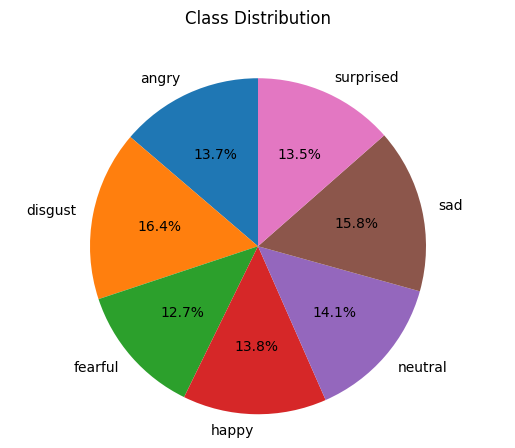

In [47]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [48]:
n_samples = 2*int(df['length'].sum()/0.1)
prob_dist = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)
choices

'disgust'

In [49]:
prob_dist

label
angry        0.137345
disgust      0.163641
fearful      0.126527
happy        0.138464
neutral      0.140784
sad          0.158006
surprised    0.135233
Name: length, dtype: float64

In [50]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [51]:
!mkdir pickles

mkdir: cannot create directory ‘pickles’: File exists


In [52]:
class Config:
  def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
    self.mode=mode
    self.nfilt=nfilt
    self.nfeat=nfeat
    self.nfft = nfft
    self.rate=rate
    self.step=int(rate/10)
    self.model_path = os.path.join('models', mode + '.model')
    self.p_path = os.path.join('pickles', mode + '.p')

In [53]:
config = Config(mode='conv')

In [54]:
def get_conv_model():
    model = Sequential()

    model.add(Conv2D(256, (3, 3), activation='relu', strides=(1, 1),
                     padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(512, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(1024, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(1024, (3, 3), activation='relu', strides=(1, 1),
                     padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))

    model.summary()

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model


In [55]:
def get_recurrent_model():
    # Assuming you have defined the input_shape somewhere before this function
    model = Sequential()

    # Add more LSTM layers with increased units
    model.add(LSTM(512, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(512, return_sequences=True))

    # Increase Dropout rate
    model.add(Dropout(0.7))

    # TimeDistributed layers with L2 regularization
    model.add(TimeDistributed(Dense(128, activation='relu')))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))

    # Increase Dropout rate
    model.add(Dropout(0.7))

    # Flatten layer
    model.add(Flatten())

    # Dense layer with L2 regularization and more units
    model.add(Dense(256, activation='relu'))

    # Output layer
    model.add(Dense(7, activation='softmax'))

    model.summary()
    optimizer = Adam(learning_rate=0.001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

    return model


In [56]:
def check_data():
  if os.path.isfile(config.p_path):
    print('Loading existing data for {} model'.format(config.mode))
    with open(config.p_path, 'rb') as handle:
      tmp = pickle.load(handle)
      return tmp
  else:
    return None

In [57]:
def build_rand_feat():
  tmp = check_data()
  if tmp:
    return tmp.data[0], tmp.data[1]
  X=[]
  y=[]
  _min, _max = float('inf'),-float('inf')
  for _ in tqdm(range(n_samples)):
    rand_class=np.random.choice(class_dist.index, p=prob_dist)
    file=np.random.choice(df[df.label==rand_class].index)
    rate, wav = wavfile.read('RAV_TESS/'+file)
    label=df.at[file, 'label']
    rand_index = np.random.randint(0, wav.shape[0]-config.step)
    sample=wav[rand_index:rand_index+config.step]
    X_sample = mfcc(sample, rate,
                    numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft).T
    _min = min(np.amin(X_sample), _min)
    _max = max(np.amax(X_sample), _max)
    X.append(X_sample if config.mode=='conv' else X_sample.T)
    y.append(classes.index(label))
  config.min=_min
  config.max = _max
  X, y = np.array(X), np.array(y)
  X = (X-_min)/(_max-_min)
  if config.mode=='conv':
    X = X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
  elif config.mode=='time':
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
  y = to_categorical(y, num_classes=7)
  config.data = (X, y)
  with open(config.p_path,'wb') as handle:
    pickle.dump(config, handle, protocol=2)

  return X, y


In [58]:
if config.mode=='conv':
  X,y = build_rand_feat()
  y_flat = np.argmax(y, axis=1)
  input_shape = (X.shape[1], X.shape[2], 1)
  model = get_conv_model()
elif config.mode=='time':
  X,y = build_rand_feat()
  y_flat = np.argmax(y, axis=1)
  input_shape = (X.shape[1], X.shape[2])
  model = get_recurrent_model()

100%|██████████| 151894/151894 [05:15<00:00, 480.82it/s]


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 9, 256)        2560      
                                                                 
 batch_normalization (Batch  (None, 13, 9, 256)        1024      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 9, 512)        1180160   
                                                                 
 batch_normalization_1 (Bat  (None, 13, 9, 512)        2048      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 4, 512)         0         
 D)                                                              
                                                      

In [59]:
input_shape

(13, 9, 1)

In [60]:
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_flat), y=y_flat)
class_weight = {i: class_weight[i] for i in range(len(class_weight))}


In [61]:
class_weight

{0: 1.034869460947294,
 1: 0.8723624208869847,
 2: 1.1450130788424282,
 3: 1.0345240933083604,
 4: 1.0068273411814614,
 5: 0.9028894793468505,
 6: 1.0563820095001635}

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 9, 256)        2560      
                                                                 
 batch_normalization (Batch  (None, 13, 9, 256)        1024      
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 9, 512)        1180160   
                                                                 
 batch_normalization_1 (Bat  (None, 13, 9, 512)        2048      
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 6, 4, 512)         0         
 D)                                                              
                                                      

In [63]:
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False, period=1)

In [64]:
history = model.fit(X, y,
          batch_size=batch_size,
          epochs=65,
          verbose=1,
          shuffle=True, class_weight=class_weight, validation_split=0.1, callbacks=[checkpoint])


Epoch 1/65
1068/1068 [==============================] - ETA: 0s - loss: 1.9701 - acc: 0.2111
Epoch 1: val_acc improved from -inf to 0.25148, saving model to models/conv.model
1068/1068 [==============================] - 101s 79ms/step - loss: 1.9701 - acc: 0.2111 - val_loss: 1.7456 - val_acc: 0.2515
Epoch 2/65
1068/1068 [==============================] - ETA: 0s - loss: 1.6609 - acc: 0.3166
Epoch 2: val_acc improved from 0.25148 to 0.39546, saving model to models/conv.model
1068/1068 [==============================] - 80s 75ms/step - loss: 1.6609 - acc: 0.3166 - val_loss: 1.5113 - val_acc: 0.3955
Epoch 3/65
1068/1068 [==============================] - ETA: 0s - loss: 1.4775 - acc: 0.4258
Epoch 3: val_acc improved from 0.39546 to 0.43825, saving model to models/conv.model
1068/1068 [==============================] - 82s 77ms/step - loss: 1.4775 - acc: 0.4258 - val_loss: 1.4686 - val_acc: 0.4382
Epoch 4/65
1068/1068 [==============================] - ETA: 0s - loss: 1.3124 - acc: 0.5077


In [65]:
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [66]:
model.save(config.model_path)

In [67]:
import shutil

In [73]:
!zip -r ./bestmodels.zip ./models
!zip -r ./bestpickles.zip ./pickles

  adding: models/ (stored 0%)
  adding: models/time.model/ (stored 0%)
  adding: models/time.model/assets/ (stored 0%)
  adding: models/time.model/saved_model.pb (deflated 90%)
  adding: models/time.model/variables/ (stored 0%)
  adding: models/time.model/variables/variables.index (deflated 67%)
  adding: models/time.model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: models/time.model/keras_metadata.pb (deflated 93%)
  adding: models/time.model/fingerprint.pb (stored 0%)
  adding: models/conv.model/ (stored 0%)
  adding: models/conv.model/assets/ (stored 0%)
  adding: models/conv.model/saved_model.pb (deflated 90%)
  adding: models/conv.model/variables/ (stored 0%)
  adding: models/conv.model/variables/variables.index (deflated 74%)
  adding: models/conv.model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/conv.model/keras_metadata.pb (deflated 95%)
  adding: models/conv.model/fingerprint.pb (stored 0%)
  adding: pickles/ (stored 0%)
  adding:

In [69]:
# !mkdir ./drive/MyDrive/SUBIINA_acc_model/
# !mkdir ./drive/MyDrive/SUBIINA_acc_model/time

In [75]:
shutil.copy('./bestmodels.zip', './drive/MyDrive/')
shutil.copy('./bestpickles.zip', './drive/MyDrive/')

'./drive/MyDrive/bestpickles.zip'

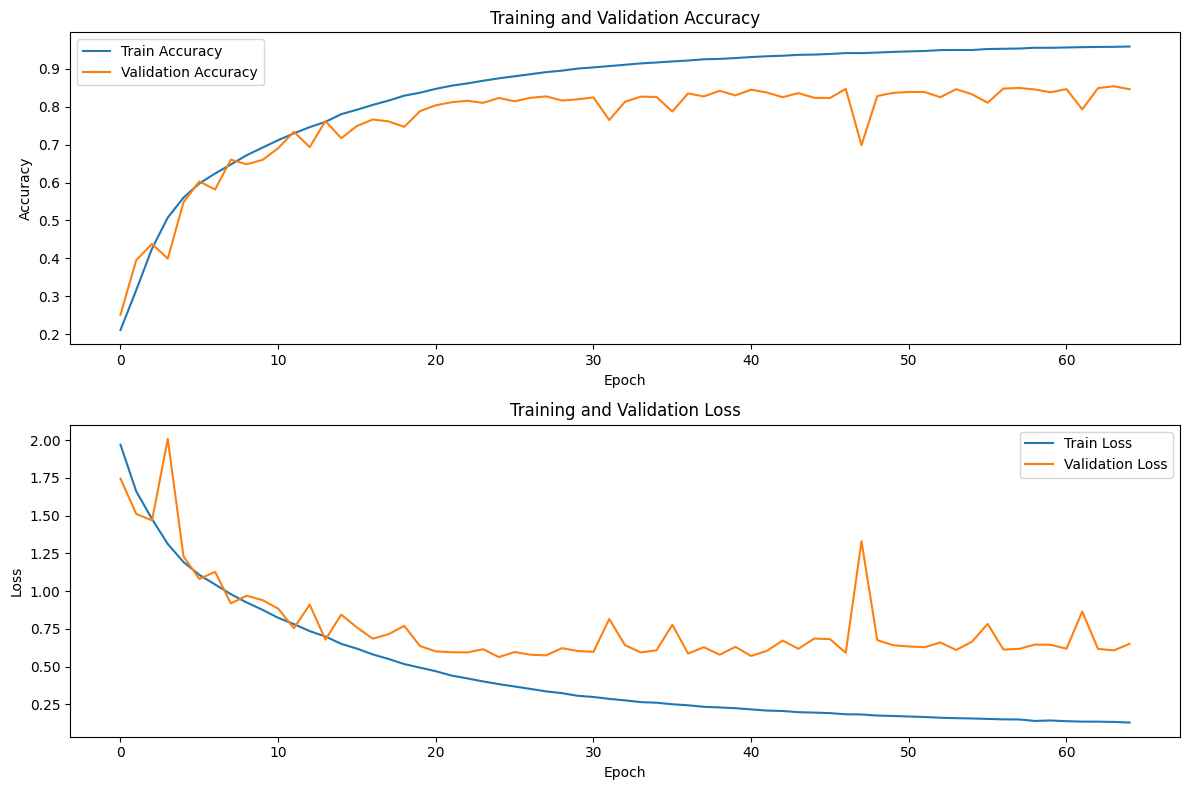

In [71]:
plt.figure(figsize=(12, 8))

# Top subplot for accuracy
plt.subplot(2, 1, 1)
plt.plot(history.history['acc'], label='Train Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Bottom subplot for loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

plt.savefig('Conv_training_plot.png')
plt.show()

In [72]:
print(len(os.listdir('RAV_TESS')))

3829
